An attempt to snick in the latent space of the Matrix Factorization happening during the Collaborative filtering.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

sql_context = sqlContext

# Organize Collaborative Filtering inside a class

In [5]:
import numpy as np
from numpy import linalg as alg

from operator import add
from pyspark.mllib.recommendation import Rating, ALS
from pyspark.ml.feature import StringIndexer
from pyspark.sql import Row
from pyspark.sql.functions import col

class CollaborativeFiltering():

    def __init__(self, rank=20, lmbda=0.01, n_iterations=10):
        """
        :rank (int): Rank of the feature matrices computed (number of features)
        :iterations (int): Number of iterations of ALS
        :lmda (float): Regularization parameter. (default: 0.01)
        """

        # CF parameters
        self.rank = rank
        self.lmbda = lmbda
        self.n_iterations = n_iterations


        # internal data structures needed for CF
        self.user_column = 'user'
        self.item_column = 'item'
        self.rating_column = 'rating'
        self.user_index_column = 'user_index'
        self.item_index_column = 'item_index'
        self.df_ratings = None
        self.rdd_ratings = None

        # The CF model itself
        self.model = None

        # Auxilliary data strucutres
        self.annoy_index = None
        self.annoy_trees = None


    def _get_rating_matrix_info(self, df,
                               user_column, user_index_column,
                               item_column, item_index_column,
                               rating_column):
        """ Preprocess data in order to get the ratings rdd (user, item, rating)
        :df (Spark DataFrame): The input DataFrame holding the user/item data
        :user_column (string): The user column name
        :user_index_column (string): The user index column name
        :item_column (string): The item column name
        :item_index_column (string): The item index column name
        :rating_column (string): The rating column name
        input e.g.
        +----+----+
        |user|item|
        +----+----+
        |   A| id1|
        |   A| id3|
        |   B| id1|
        |   C| id5|

        output ratings data frame e.g.
        +----+------+----+----------+----------+
        |item|rating|user|user_index|item_index|
        +----+------+----+----------+----------+
        | id5|     1|   C|         2|         2|
        | id1|     1|   B|         1|         0|
        | id3|     1|   A|         0|         1|

        output ratings rdd e.g.
        [Rating(user=2, product=2, rating=1.0),
         Rating(user=2, product=4, rating=1.0),
         Rating(user=1, product=5, rating=1.0), ...]

        """

        # clear data
        # e.g. user has seen only one item - does not contribute to collborative intelligence
        user_items_df = \
            df.rdd.groupByKey()\
                  .map(lambda (user, items): (user, len(items)))\
                  .map(lambda (user, n_items): Row(user=user, n_items=n_items))\
                  .toDF()
        df = df.join(user_items_df, [user_column])
        df = df.filter(df['n_items'] > 1).select([user_column, item_column])


        # Get ratings matrix
        # +----+------+----+
        # |item|rating|user|
        # +----+------+----+
        # | id5|     1|   C|
        # | id6|     1|   C|
        # | id4|     1|   B|
        df_ratings = df.rdd\
            .map(lambda (user, item): ((user, item), 1))\
            .reduceByKey(add)\
            .map(lambda ((user, item), rating): Row(user=user, item=item, rating=rating))\
            .toDF()

        # Index user / item values for ALS input
        # we cast explicitly to integer. If not result is real and ALS performance drops dramatically
        df_ratings = StringIndexer(inputCol=user_column,
                                   outputCol=user_index_column,
                                   handleInvalid="skip")\
            .fit(df_ratings)\
            .transform(df_ratings)\
            .withColumn(user_index_column, col(user_index_column).cast("integer"))

        df_ratings = StringIndexer(inputCol=item_column,
                                   outputCol=item_index_column,
                                   handleInvalid="skip")\
            .fit(df_ratings)\
            .transform(df_ratings)\
            .withColumn(item_index_column, col(item_index_column).cast("integer"))

        # get ratings rdd
        rdd_ratings = df_ratings\
            .select([user_index_column, item_index_column, rating_column])\
            .rdd.map(lambda (user, item, rating): Rating(user, item, rating))

        return df_ratings, rdd_ratings


    def train(self, df):
        """ Training of Collabrative Filtering model.
        This is a wrapper, see details in doc strings of functions below
        :df (Spark DataFrame): The input DataFrame holding the user/item data
        input e.g.
        +----+----+
        |user|item|
        +----+----+
        |   A| id1|
        |   A| id3|
        |   B| id1|
        |   C| id5|
        """

        # get rating objects
        (self.df_ratings, self.rdd_ratings) = self._get_rating_matrix_info(df,
            self.user_column, self.user_index_column,
            self.item_column, self.item_index_column,
            self.rating_column)

        # train the ALS model (implicit because we have implicit ratings)
        self.model = ALS.trainImplicit(self.rdd_ratings,
                                  self.rank,
                                  self.n_iterations,
                                  self.lmbda)


    def recommend_products(self, n_top_products):
        return self.model.recommendProductsForUsers(n_top_products).collect()

# Synthesize our Data

We synthesize our input data to match a typical recommendation problem, user-item Matrix. We have 5 users choosing among few products. Many of the user have same products of preference. 

On purpose we give names to the items that reveal their collor. This is done in order to be able to validate later if this collor preference is reflected in the latent space. 

In [3]:
df = sql_context.createDataFrame([( 'Tom', 'red_shoes'),  
                                  ( 'Tom', 'red_pen'),
                                  ( 'Tom', 'red_bag'),
                                  
                                  ( 'Christian', 'blue_drone'),
                                  ( 'Christian', 'blue_watch'),
                                  ( 'Christian', 'blue_headphones'),
                                  
                                  ( 'Mary', 'red_shoes'),  
                                  ( 'Mary', 'red_hat'),
                                  ( 'Mary', 'red_bag'),
                                  
                                  ( 'Joe', 'yellow_boots'),  
                                  ( 'Joe', 'yellow_ombrella'),
                                  ( 'Joe', 'yellow_book'),
                                                                    
                                  ( 'Nick', 'blue_drone'),
                                  ( 'Nick', 'blue_glasses'),
                                  ( 'Nick', 'blue_headphones')
                                 ], 
                                 [ "user", "item"])

print "We have N distinct users: ", df.select('user').distinct().count()
print "We have N distinct items: ", df.select('item').distinct().count()

df.show(4)

We have N distinct users:  5
We have N distinct items:  11
+---------+----------+
|     user|      item|
+---------+----------+
|      Tom| red_shoes|
|      Tom|   red_pen|
|      Tom|   red_bag|
|Christian|blue_drone|
+---------+----------+
only showing top 4 rows



# Perform Colloaborative Filtering

In [6]:
# we choose latent factor = 2 because we want to project the results directly in the 2d space
RANK = 2

cf = CollaborativeFiltering(rank=RANK)
cf.train(df)

In [7]:
# internally the CF assigns indexes to users and items 
print cf.df_ratings.take(2)

[Row(item=u'blue_headphones', rating=1, user=u'Nick', user_index=2, item_index=1), Row(item=u'yellow_ombrella', rating=1, user=u'Joe', user_index=0, item_index=9)]


In [9]:
# we access the latent space of users and create the relevant dataframe
df_user_latent = sql_context.createDataFrame(
    cf.model.userFeatures(), 
    ['user_index', 'user_latent_vec'])
df_user_info = cf.df_ratings.select(['user', 'user_index'])
df_user_latent = df_user_latent.join(df_user_info, ['user_index'])
df_user_latent.show(2)

+----------+--------------------+----+
|user_index|     user_latent_vec|user|
+----------+--------------------+----+
|         0|[0.02588073164224...| Joe|
|         0|[0.02588073164224...| Joe|
+----------+--------------------+----+
only showing top 2 rows



In [10]:
# same for items
df_item_latent = sql_context.createDataFrame(cf.model.productFeatures(), 
                                             ['item_index', 'item_latent_vec'])
df_item_info = cf.df_ratings.select(['item', 'item_index'])
df_item_latent = df_item_latent.join(df_item_info, ['item_index'])
df_item_latent.show(2)

+----------+--------------------+-------+
|item_index|     item_latent_vec|   item|
+----------+--------------------+-------+
|         0|[-0.1131361946463...|red_bag|
|         0|[-0.1131361946463...|red_bag|
+----------+--------------------+-------+
only showing top 2 rows



In [11]:
# keep as dictionaries the latent info of users/items
user_latent_info = df_user_latent.rdd\
  .map(lambda (user_index, user_latent_vec, user): ((user_index, user), user_latent_vec))\
  .collectAsMap()


item_latent_info = df_item_latent.rdd\
  .map(lambda (item_index, item_latent_vec, user): ((item_index, user), item_latent_vec))\
  .collectAsMap()


# Plot

In [13]:
import random
def get_latent_space_values(latent_d):
    x = [];
    y = []
    labels = []
    for k, v in latent_d.iteritems():
        # we add on purpose a tiny noise fuctor so not to have overlaping points
        epsilon = random.uniform(0, 0.15)
        x.append(v[0]+epsilon)
        y.append(v[1]+epsilon)
        user = k[1]
        labels.append(user)
    return (x, y, labels)
  
def get_latent_space_fig(x, y, labels, title=""):
    fig, ax = plt.subplots(figsize=(5,5))
    fig.suptitle(title, fontsize=10, fontweight='bold')
    for i, label in enumerate(labels):
        #plt.annotate(label, (x[i], y[i]))
        ax.text(x[i], y[i], label)
    plt.scatter(x, y)
    plt.show()
    return fig

### Latent space with Items

As we see the latent space of items, shows that _blue_ items are somehow located together, _red_ items are somehow again located together and _yellow_ items have their own corner. It is important to remember that we have not given any explicit information of those items. The only reason they are grouped is because the users that buy them have the preference on color. The items are grouped together just because their relevant users like them, and as a result in the latent space we see that this happens because the users have some preference in the color. 

In this view, the latent space can be regarded as a _color_ space, where red lays in the (x, y) ~ (0. 1) ,  blue lays in the region (x, y) ~ (-0.5, 0) and yellow lays in the region (x, y) ~ (0, 0).

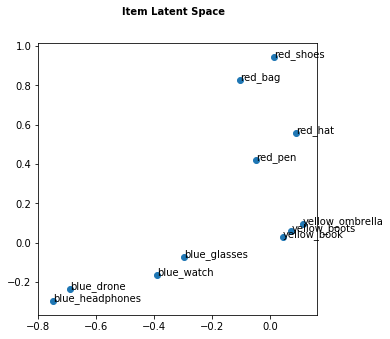

In [16]:
(x_items, y_items, labels_items) = get_latent_space_values(item_latent_info)
fig = get_latent_space_fig(x_items, y_items, labels_items, title='Item Latent Space')
#display(fig)

### Latent space with Users

Similarily we can see the latent space of users. Here we notice that users are grouped together, just because of their common item preferences. 

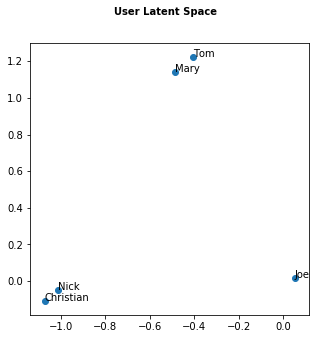

In [18]:
(x_users, y_users, labels_users) = get_latent_space_values(user_latent_info)
fig = get_latent_space_fig(x_users, y_users, labels_users, title='User Latent Space')

### Latent space (users & items)

Finally we dump all user and items in the same plot. It is the same latent space they share so we would think that the correlated users and their relevant items will lay in the same area. Lets plot them to validate thid hypothesis

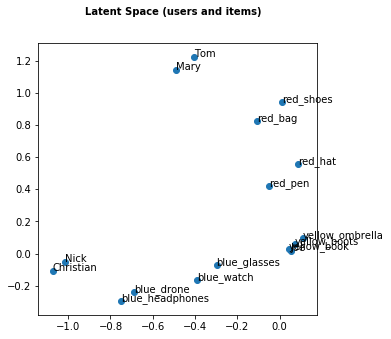

In [20]:
fig = get_latent_space_fig(x_users + x_items, 
                           y_users + y_items, 
                           labels_users + labels_items, 
                           title='Latent Space (users and items)')

So as we can see, not perfectly but the trend is there. The users of the red item preferences are close to the red colored items in the latent space. The same happens with the rest of the users. 

This last observation, make us think that such information can be used for personalized recommendations using this latent space. Since we can give higher scores to the items that lay closer to the user. Would not bet my last dollar on that, and this idea can be elaborated, but probably we sit on something. 

Anyway, 3 plots per notebook are good enough, we catchup with that in a supsequent story ;-)